### MNIST dataset MLP example with synapgrad

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

# Import .././ directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from synapgrad.nn.utils.data import split_dataset, DataLoader, DataLoaderCallback
from synapgrad.nn.utils.train import Trainer, Evaluator

In [3]:
supported_engines = ['synapgrad', 'torch']

In [4]:
seed = 42
engine_str = 'synapgrad'

In [5]:
epochs = 20
batch_size = 64
lr = 0.01

In [6]:
if engine_str == 'synapgrad':
    import synapgrad as engine
    from synapgrad import nn
    from synapgrad import optim
elif engine_str == 'torch':
    import torch as engine
    from torch import nn
    from torch import optim
engine.manual_seed(seed)
print("Engine:", engine_str)

Engine: synapgrad


Load dataset

In [7]:
train_set = datasets.MNIST('./mnist', train=True, download=True)
test_set = datasets.MNIST('./mnist', train=False, download=True)

trainX = train_set.data.numpy()
trainY = train_set.targets.numpy()
testX = test_set.data.numpy()
testY = test_set.targets.numpy()

(trainX, trainY), (valX, valY), _  = split_dataset(trainX, trainY, test_split=0.2)

trainX = trainX / 255.0
valX = valX / 255.0
testX = testX / 255.0

assert 0 <= np.max(trainX) <= 1

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Val: X=%s, y=%s' % (valX.shape, valY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

Train: X=(48000, 28, 28), y=(48000,)
Val: X=(12000, 28, 28), y=(12000,)
Test: X=(10000, 28, 28), y=(10000,)


In [8]:
class Transform(DataLoaderCallback):
    
    def __call__(self, data_loader:'DataLoader', X_batch:np.ndarray, y_batch:np.ndarray):
        if engine_str == 'torch':
            x = engine.tensor(X_batch).type(engine.FloatTensor)
            y = engine.tensor(y_batch).type(engine.LongTensor)
        elif engine_str == 'synapgrad':
            x = engine.tensor(X_batch)
            y = engine.tensor(y_batch, dtype=np.int8)
        return x, y

transform_cb = Transform()

train_loader = DataLoader(trainX, trainY, batch_size, transform=transform_cb)
val_loader = DataLoader(valX, valY, batch_size=256, transform=transform_cb) # big batch size for val samples
test_loader = DataLoader(testX, testY, batch_size=256, transform=transform_cb) # big batch size for test samples

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader), "| Test batches:", len(test_loader))

Train batches: 750 | Val batches: 46 | Test batches: 39


Plot a few training images

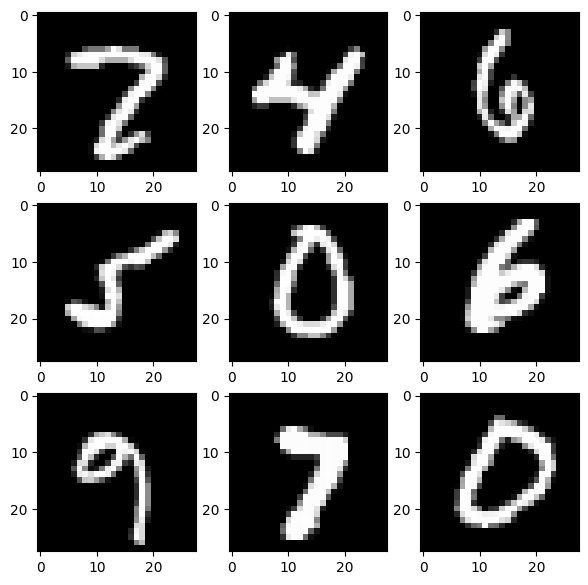

In [9]:
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

In [10]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.mlp = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(784, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x:engine.Tensor):
        out = self.mlp(x)
        
        return out

model = MultiLayerPerceptron()
print("MLP Model:", model)
print("MLP Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MLP Model: MultiLayerPerceptron(submodules=1, parameters=178710, trainable=178710, non_trainable=0)
MLP Trainable Parameters: 178710


In [11]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

trainer = Trainer(model, engine)
evaluator = Evaluator(accuracy=True, mode=Evaluator.MULTI_CLASS)
trainer.compile(loss_fn, optimizer, evaluator)
history = trainer.fit(train_loader, epochs=epochs, validation_loader=val_loader)

Epoch: 1/20
750/750 [================================] - 42s 56ms/step - loss: 0.4081 - accuracy: 0.8795 - val_loss: 0.1746 - val_accuracy: 0.9451
Epoch: 2/20
750/750 [================================] - 47s 62ms/step - loss: 0.2037 - accuracy: 0.9380 - val_loss: 0.1352 - val_accuracy: 0.9596
Epoch: 3/20
750/750 [================================] - 47s 63ms/step - loss: 0.1573 - accuracy: 0.9526 - val_loss: 0.1185 - val_accuracy: 0.9648
Epoch: 4/20
750/750 [================================] - 50s 67ms/step - loss: 0.1318 - accuracy: 0.9585 - val_loss: 0.1074 - val_accuracy: 0.9685
Epoch: 5/20
750/750 [================================] - 48s 64ms/step - loss: 0.1157 - accuracy: 0.9642 - val_loss: 0.1009 - val_accuracy: 0.9700
Epoch: 6/20
 95/750 [===>............................] - ETA: 43s - loss: 0.1091 - accuracy: 0.9630

In [ ]:
trainer.plot(['accuracy', 'loss'], ylim=[0, 1])

In [ ]:
y_pred, y_true = trainer.test(test_loader)
evaluator.report(y_pred, y_true)

In [ ]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(testX[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    pred = y_pred[i].argmax(); label = y_true[i]
    plt.title(f"Pred: {pred} | Class: {label}")
plt.show()